## Retail Store Sales Forecasting with Neural Networks -  Vanilla Stacked Bidirectional LSTM
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

Using TensorFlow backend.


## Load Dataset

In [2]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [7]:
#furniture['sales']

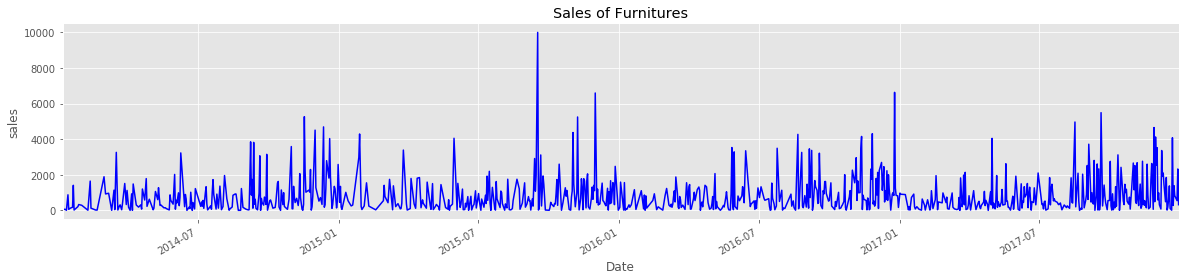

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [9]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

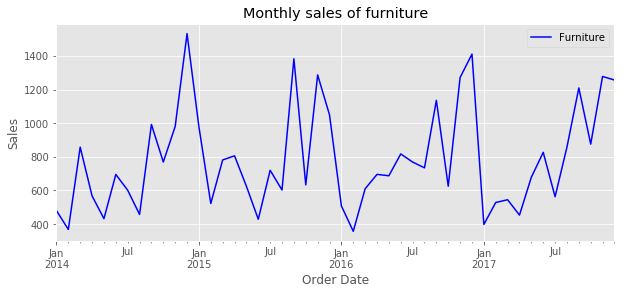

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")

In [12]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [13]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [49]:
n_input = 12
# Univariate
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10) #or6

### Vanilla LSTM

In [87]:
model_vanilla = Sequential()
model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
#Add layer
model_vanilla.add(Dense(100, activation='relu'))
model_vanilla.add(Dense(100, activation='relu'))
#Output
model_vanilla.add(Dense(1))
model_vanilla.compile(optimizer='adam', loss='mse')
# 22

In [82]:
model_vanilla.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 3s 1s/step - loss: 0.2049
Epoch 2/200
3/3 [==============================] - 0s 48ms/step - loss: 0.1225
Epoch 3/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0947
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1036
Epoch 5/200
3/3 [==============================] - 0s 62ms/step - loss: 0.0876
Epoch 6/200
3/3 [==============================] - 0s 47ms/step - loss: 0.0717
Epoch 7/200
3/3 [==============================] - 0s 43ms/step - loss: 0.0796
Epoch 8/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0787
Epoch 9/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0788
Epoch 10/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0753
Epoch 11/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0768
Epoch 12/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0727
Epoch 13/200
3/3 [==============================] -

In [84]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model_vanilla.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_vanilla], axis=1)

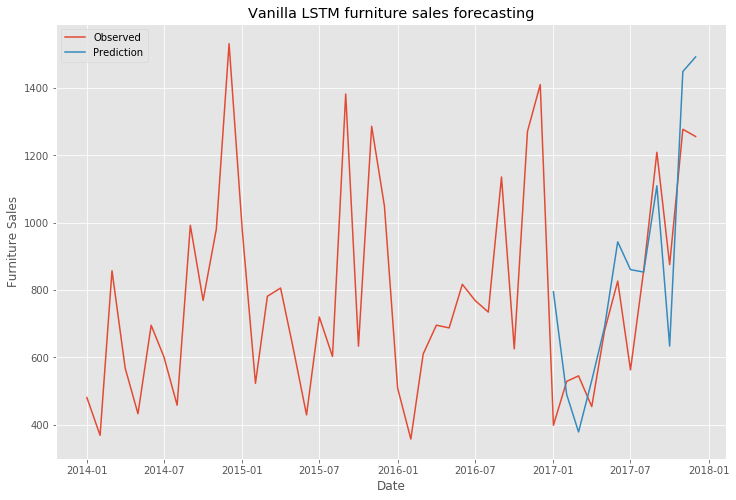

In [85]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,df_predict_vanilla,label="Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [86]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))
performance(df[-12:],df_predict_vanilla['Prediction'] )

#mmape can be 18

 The MSE of forecasts is 37453.97
 The RMSE of forecasts is 193.53
 The MAPE of forecasts is 24.35


### Stacked LSTM

In [55]:
model_stacked = Sequential()
#In stackes LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(100, activation='relu'))
model_stacked.add(Dense(50, activation='relu'))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')
#15



In [56]:
model_stacked.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 802ms/step - loss: 0.2415
Epoch 2/200
3/3 [==============================] - 0s 47ms/step - loss: 0.2184
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1926
Epoch 4/200
3/3 [==============================] - 0s 30ms/step - loss: 0.1627
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 0.1264
Epoch 6/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1035
Epoch 7/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0707
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0868
Epoch 9/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0874
Epoch 10/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0852
Epoch 11/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0765
Epoch 12/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0719
Epoch 13/200
3/3 [==============================

In [57]:
pred_list_s = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_s.append(model_stacked.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_stacked], axis=1)

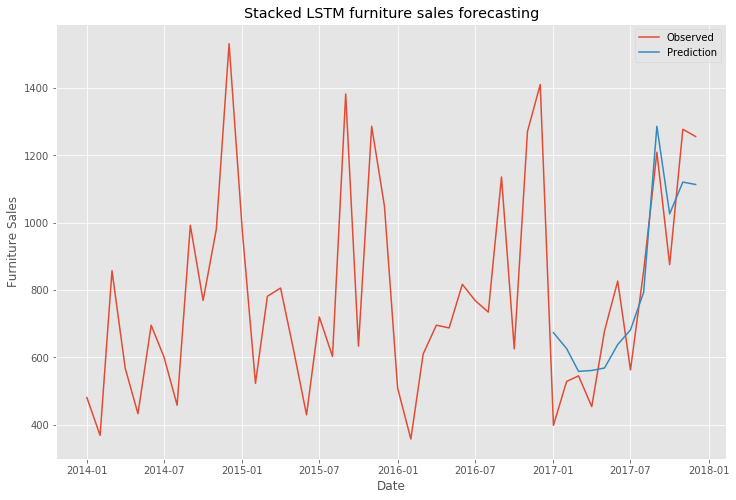

In [58]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,df_predict_stacked,label="Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [59]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))
performance(df[-12:],df_predict_stacked['Prediction'] )

 The MSE of forecasts is 19751.12
 The RMSE of forecasts is 140.54
 The MAPE of forecasts is 19.08


### Bidirectional LSTM

In [73]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [74]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 3s 872ms/step - loss: 0.2455
Epoch 2/200
3/3 [==============================] - 0s 41ms/step - loss: 0.2149
Epoch 3/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1873
Epoch 4/200
3/3 [==============================] - 0s 33ms/step - loss: 0.1660
Epoch 5/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1447
Epoch 6/200
3/3 [==============================] - 0s 31ms/step - loss: 0.1268
Epoch 7/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1064
Epoch 8/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0880
Epoch 9/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0788
Epoch 10/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0720
Epoch 11/200
3/3 [==============================] - 0s 37ms/step - loss: 0.0687
Epoch 12/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0769
Epoch 13/200
3/3 [==============================

In [75]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict_bi], axis=1)

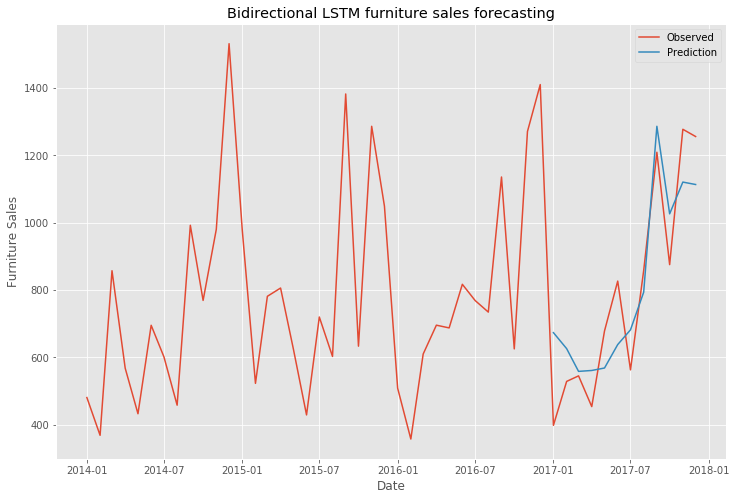

In [88]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,df_predict_bi,label="Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [78]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))
performance(df[-12:],df_predict_bi['Prediction'] )

 The MSE of forecasts is 19751.12
 The RMSE of forecasts is 140.54
 The MAPE of forecasts is 19.08


## source:

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/